# Atlanta Braves Batting Comparison Between 2020 and 2021

After an incredibly successful 2020 season for the Atlanta Braves, the start of the 2021 season can be summed up by one word. Disappointing.

The team that was a top 5 offensive team in the pandemic shortened 60 game 2020 season has fallen to be a below average offensive team in 2021. Yes, there have been injuries. Yes, there were some personnel changes. And yes, there were some legal issues with the marquee free agent signing. However, when watching the games the biggest issue has seemed to be the clutch hit when it is needed most.

I was interested in how different the offensive has really been or if it has been an issue of "timely" hitting. To do this I am going to compare the 60 game 2020 season with the first 60 games of the 2021 season.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import warnings
warnings.filterwarnings("ignore")

I downloaded the game by game hitting logs for the braves in the 2020 and 2021 seasons from www.baseball-reference.com.

I then added some columns that would help me better analyze the data.

In [132]:
df_20 = pd.read_csv('braves_batting_20.csv',header=0)
df_21 = pd.read_csv('braves_batting_21.csv',header=0)
# Add the year to the respective data set
df_20['Year']=2020
df_21['Year']=2021
#Combine the datasets
df = pd.concat([df_20,df_21])
#Split out results into win/loss, scores, score diff, home/away
rslt = df['Rslt'].str.split(',',expand =True)
scores = rslt[1].str.split('-',expand=True)
df['W_L']=rslt[0]
df['opp_score'] = pd.to_numeric(scores[1])
df['score_diff'] = np.abs(df['R']-df['opp_score'])
df['H_A'] = np.where(df['Unnamed: 3']=='@','Away','Home')
#Create baserunners category to describe total activity on basepath
df['BR']=df['H']+df['BB']+df['HBP']+df['ROE']
#k% category to level out number of PA
df['K_perc']=df['SO']/df['PA']
#Drop unneeded columns
df.drop(columns=['Rk','Unnamed: 3','Rslt'], inplace=True)
#First 60 games
df = df[df['Gtm']<=60]
df.columns

Index(['Gtm', 'Date', 'Opp', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'BA',
       'OBP', 'SLG', 'OPS', 'LOB', '#', 'Thr', 'Opp. Starter (GmeSc)', 'Year',
       'W_L', 'opp_score', 'score_diff', 'H_A', 'BR', 'K_perc'],
      dtype='object')

## Histogram Analysis
Looking at the possible variables to compare, I wanted to get a sense for where there may be a larger differences for a starting point.

In [133]:
def hists(data, comp, vars,title):
    fig, axes = plt.subplots(2,int(round(len(vars)/2)),figsize=(20,10))
    groups = data[comp].unique()
    for var, ax in zip(vars,axes.reshape(-1)):
        for group in groups:
            sns.distplot(data.loc[data[comp]==group, var], label=str(group),ax=ax)
        ax.set(title=var+' Distribution')
        ax.legend(loc='upper right')
    fig.suptitle(title)
    fig.tight_layout()
    fig.show()

The below distribution plots show that most areas seem to be roughly in line with 2020's performance with the exception of the classic triple slash metrics (BA/OBP/SLG).<p>
However, I would like to know if the distributions of some of the other variables can be found to be statistically significant with ANOVA.

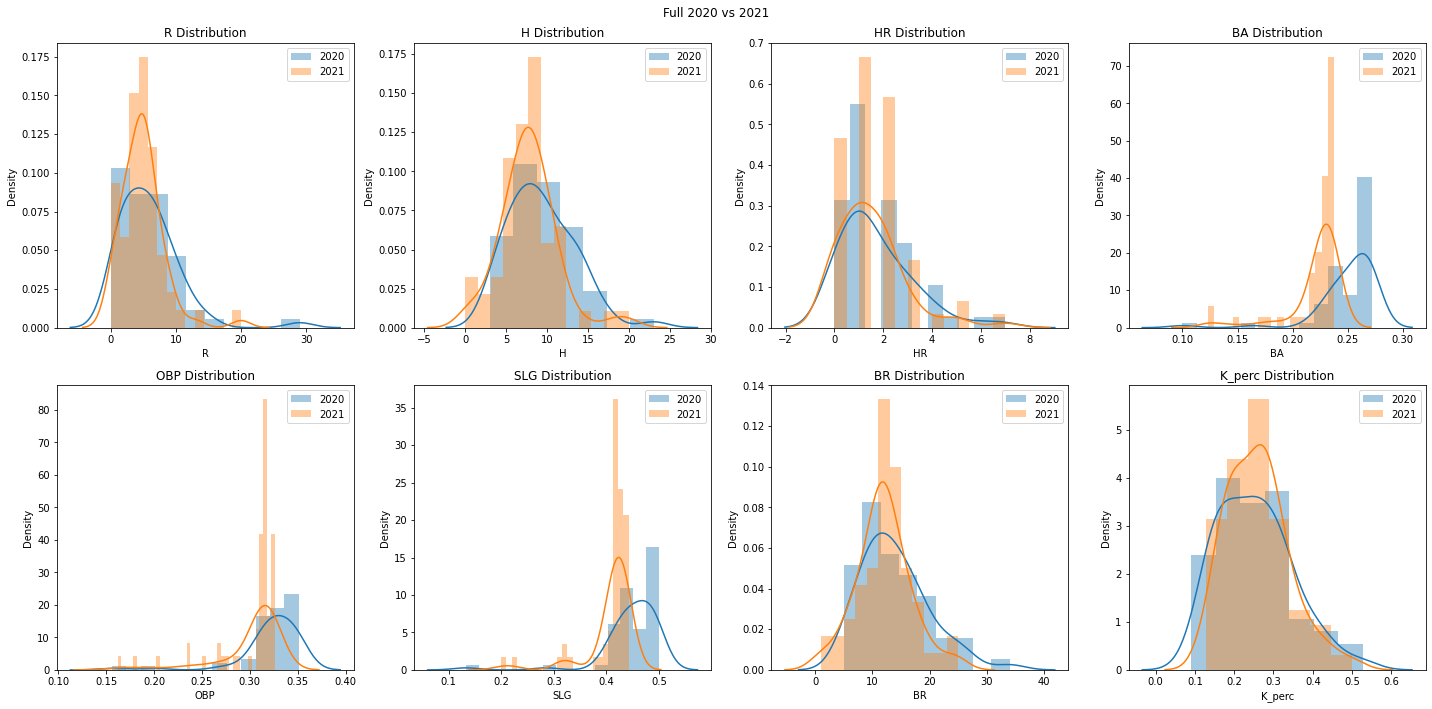

In [142]:
variables = ['R','H','HR','BA','OBP','SLG','BR','K_perc']
hists(df,'Year',variables,'Full 2020 vs 2021')


## ANOVA Formula
The below formula will:<p>
    -Create an ANOVA model with the specified independent and dependent variables <p>
    -Print the model summary<p>
    -Print the tukey pair wise comparison<p>
    -Plot the box plots<p>
    -Plot the residuals to check for a fit to normal distribution (additional shapiro-wilks test)<p>
    -Check for even variance between the groups<p>

In [152]:
def anova_analysis(data, x, y):
    # Build Model & Print Summary
    model = ols(y+'~ C('+x+')',data).fit()
    anova_table = sm.stats.anova_lm(model,typ=2)
    print("ANOVA SUMMARY for "+y+":\n",anova_table)
    #Tukey pair-wise results
    mc = statsmodels.stats.multicomp.MultiComparison(data[y],data[x])
    mc_results = mc.tukeyhsd()
    print(mc_results)
    #Plot 
    fig1, ax1 = plt.subplots(1,figsize=(5,5))
    ax1 = sns.boxplot(x=x, y=y, data=data)
    ax1.set(title=y+' by '+ x)
    fig1.show()

    groups = data[x].unique()

    fig, axes = plt.subplots(1,len(groups),figsize=(10,5))
    for group, ax in zip(groups,axes.reshape(-1)):
        stats.probplot(data.loc[data[x]==group,y],dist='norm',plot=ax)
        ax.set_title(str(group)+' '+y+' Q-Q')
    fig.tight_layout()
    fig.show()

    print(stats.shapiro(model.resid))
    ratio = data[[x,y]].groupby(x).std().max() / data[[x,y]].groupby(x).std().min()
    print("Max to Min Standard Deviation Ratio:",ratio)


## Runs, Baserunners, & Strikeout Analysis
The main complaints for the season have been the losses (obviously) and the "All or Nothing" approach. To look into these, I want to dive into the number of runs scored, since you can't win without scoring runs, and the total baserunners and the K% since both directly effect the amount of activity in the game.

ANOVA SUMMARY for R:
                sum_sq     df         F    PR(>F)
C(Year)     28.033333    1.0  1.699921  0.194836
Residual  1945.933333  118.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  2020   2021  -0.9667 0.1948 -2.4349 0.5015  False
---------------------------------------------------
ShapiroResult(statistic=0.8458683490753174, pvalue=7.617399488957233e-10)
Max to Min Standard Deviation Ratio: R    1.434587
dtype: float64
ANOVA SUMMARY for BR:
                sum_sq     df         F   PR(>F)
C(Year)    118.008333    1.0  4.044688  0.04659
Residual  3442.783333  118.0       NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2020   2021  -1.9833 0.0466 -3.9362 -0.0304   True
----------------------------------------------------

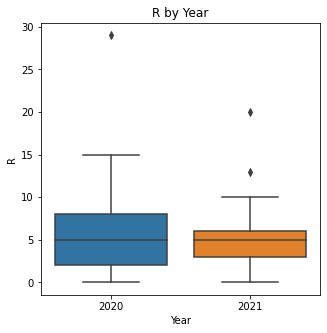

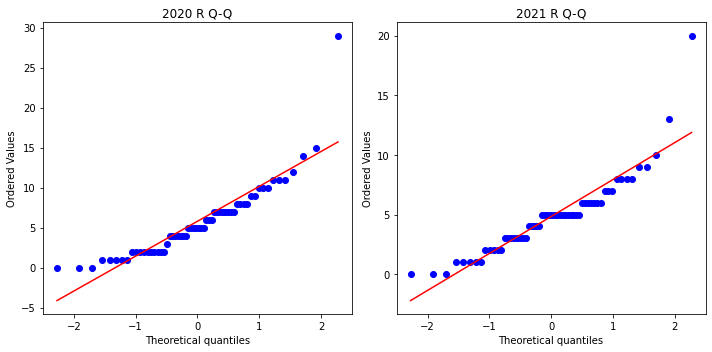

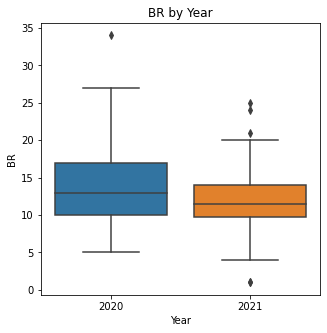

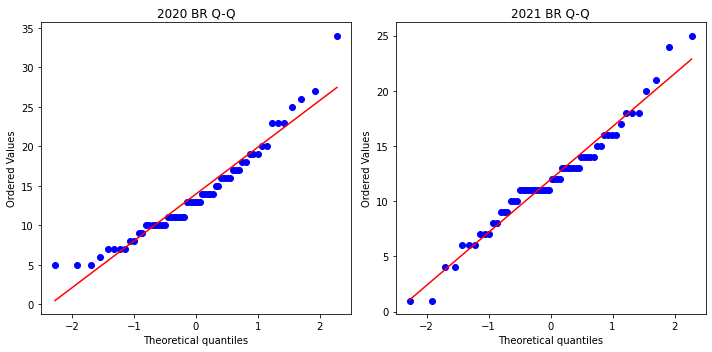

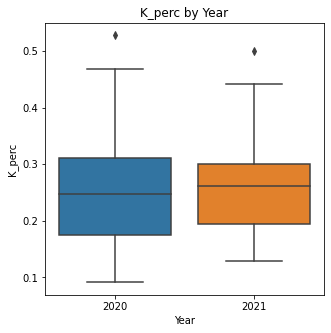

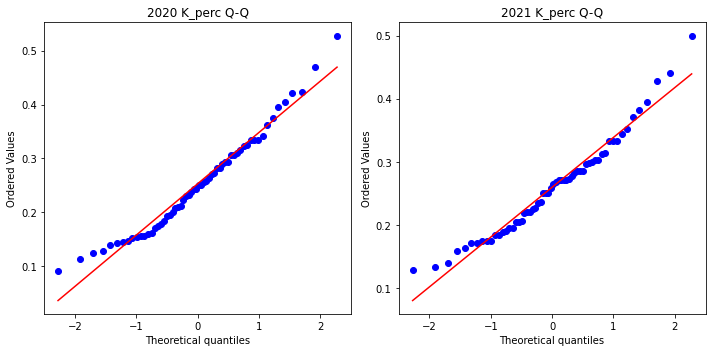

In [153]:
anova_analysis(data=df,x='Year',y='R')
anova_analysis(data=df,x='Year',y='BR')
anova_analysis(data=df,x='Year',y='K_perc')

Looking at each of these ANOVA outputs we can say that K% and runs haven't changed in a significant way since the p-value is greater than 0.05. Using p<0.05, the number of baserunners has changed in a significant manner (about 2 runners per game), but that is to be expected due to the drop in OBP.

## Looking at Subsets of Data
Since the classic sports complaints only really come out in losses and when fans are forced to sweat out a W, there are a couple of other ways to see if the 2021 batting performances have been different.<p>
-Looking at only losses<p>
-Looking at only close games (run differential of 4 runs or less)

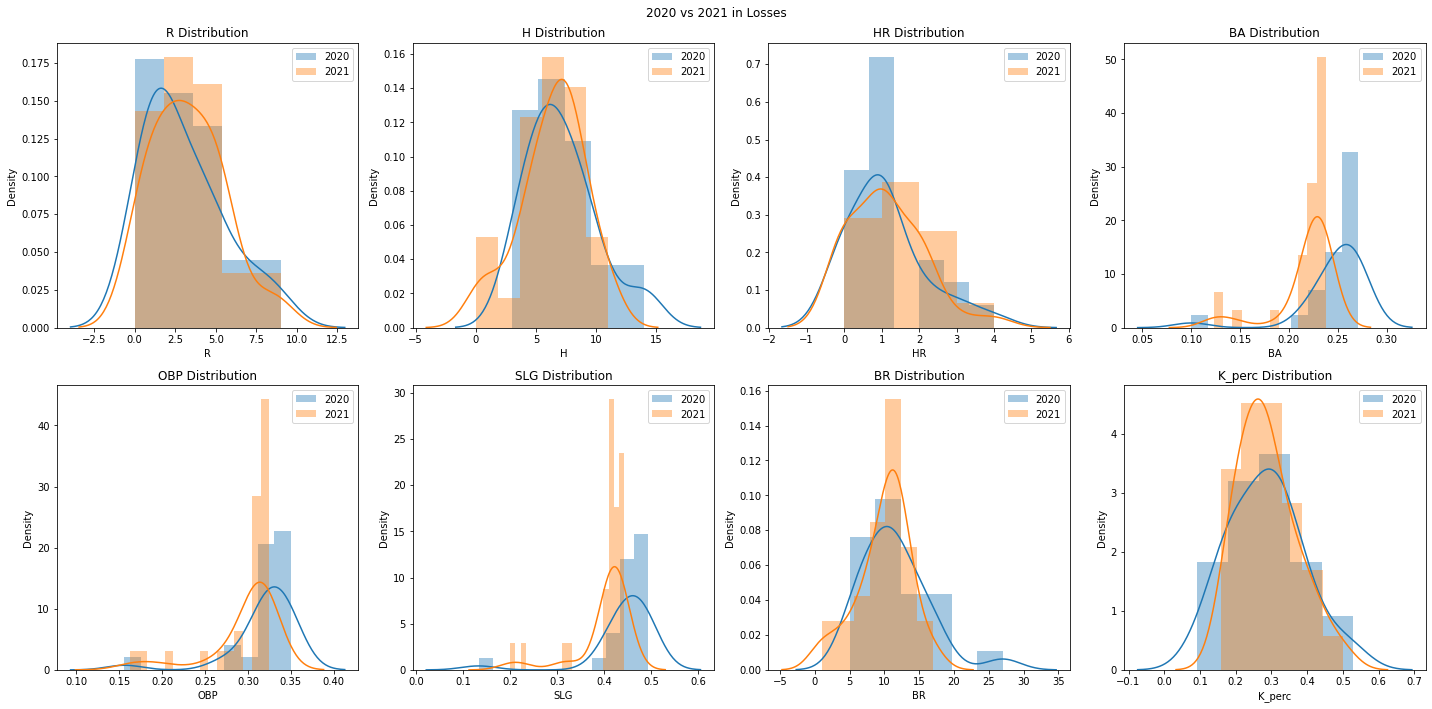

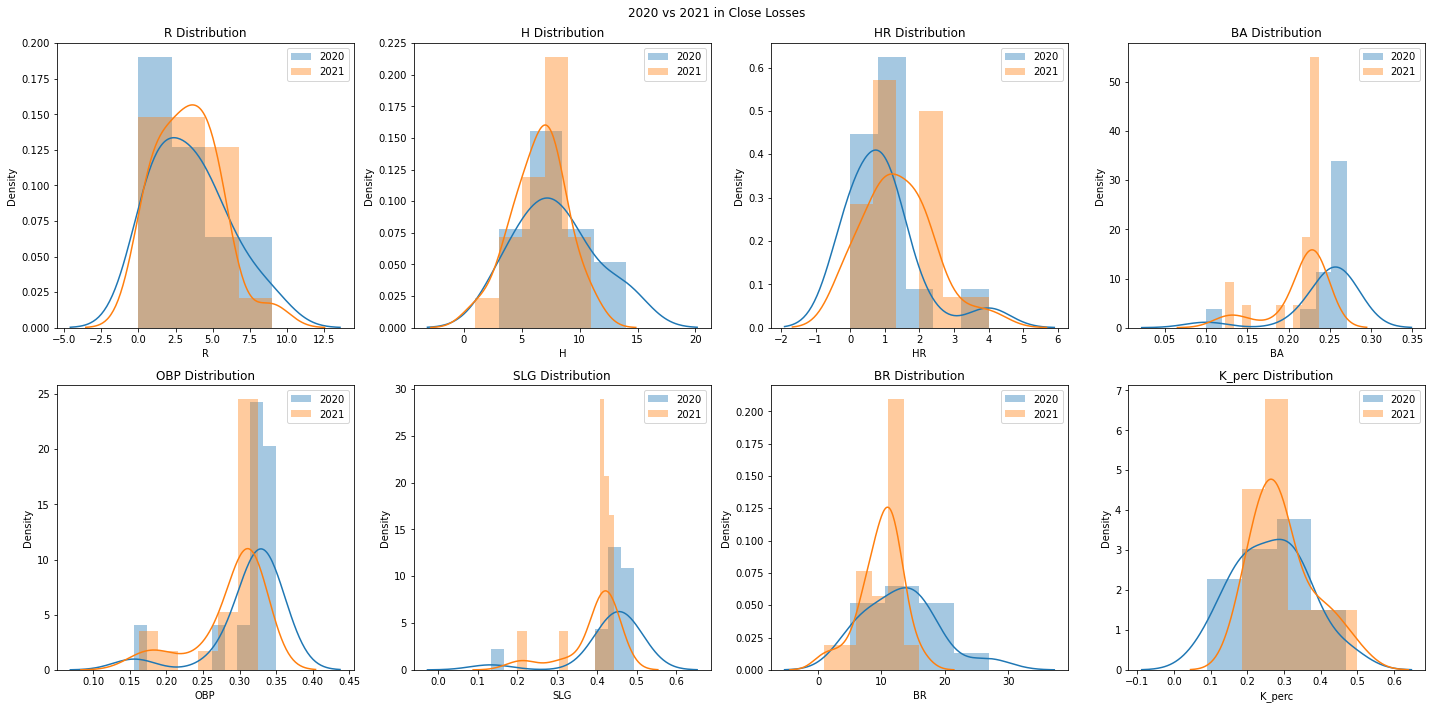

In [179]:
#Data set for only close games where the final score is decided by 4 or fewer runs
close_df = df[df['score_diff']<=4]
#Data set for losses
loss_df = df[df['W_L']=='L']

hists(loss_df,'Year',variables, '2020 vs 2021 in Losses')
hists(closeloss_df,'Year',variables, '2020 vs 2021 in Close Losses')

## Loss Analysis

ANOVA SUMMARY for R:
               sum_sq    df         F    PR(>F)
C(Year)     0.867189   1.0  0.153361  0.696886
Residual  305.347097  54.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
  2020   2021   0.2503 0.708 -1.0312 1.5319  False
--------------------------------------------------
ShapiroResult(statistic=0.9394070506095886, pvalue=0.007327646482735872)
Max to Min Standard Deviation Ratio: R    1.105555
dtype: float64
ANOVA SUMMARY for BR:
                sum_sq    df        F    PR(>F)
C(Year)     34.407465   1.0  1.84518  0.179993
Residual  1006.949677  54.0      NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
  2020   2021  -1.5768  0.18 -3.904 0.7505  False
-------------------------------------------------
ShapiroResult(statistic=0.

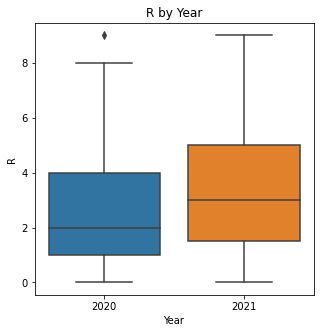

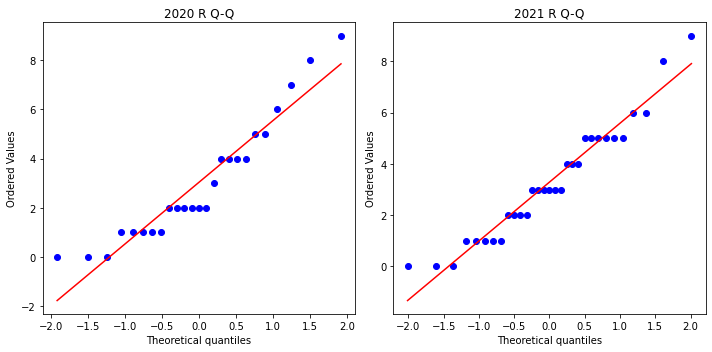

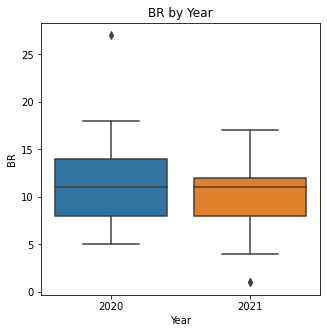

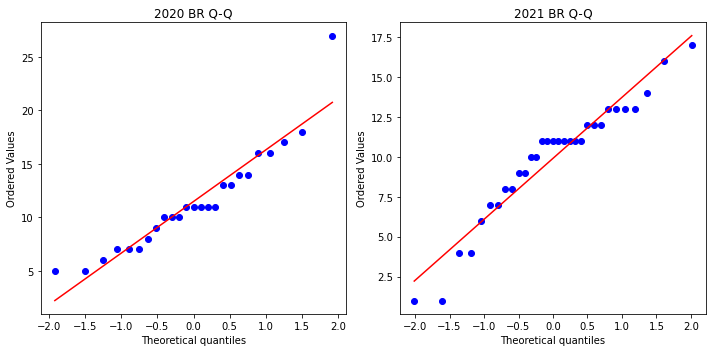

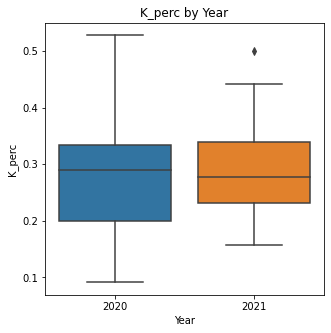

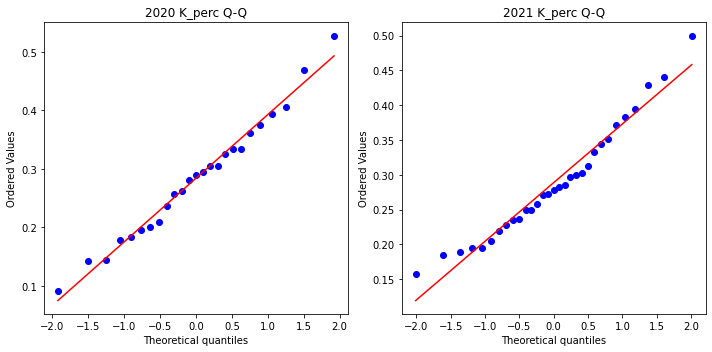

In [180]:
anova_analysis(data=loss_df,x='Year',y='R')
anova_analysis(data=loss_df,x='Year',y='BR')
anova_analysis(data=loss_df,x='Year',y='K_perc')

Now this is interesting. In losses, the metrics that we are tracking are all pretty clearly not statistically different from the 2020 season. In fact, the average number of runs is actually higher in 2021 in losses which points to pitching or defense potentially being the issue in these games.

## Close Game Analysis

ANOVA SUMMARY for R:
               sum_sq    df         F    PR(>F)
C(Year)     4.573971   1.0  0.722941  0.397887
Residual  474.516938  75.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
  2020   2021  -0.4885 0.3979 -1.633 0.656  False
-------------------------------------------------
ShapiroResult(statistic=0.975728452205658, pvalue=0.14743250608444214)
Max to Min Standard Deviation Ratio: R    1.269514
dtype: float64
ANOVA SUMMARY for BR:
                sum_sq    df         F    PR(>F)
C(Year)     74.714004   1.0  3.453638  0.067037
Residual  1622.506775  75.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
  2020   2021  -1.9743 0.067 -4.0906 0.142  False
-------------------------------------------------
ShapiroResult(statistic=0.984

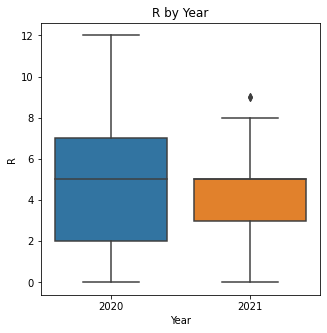

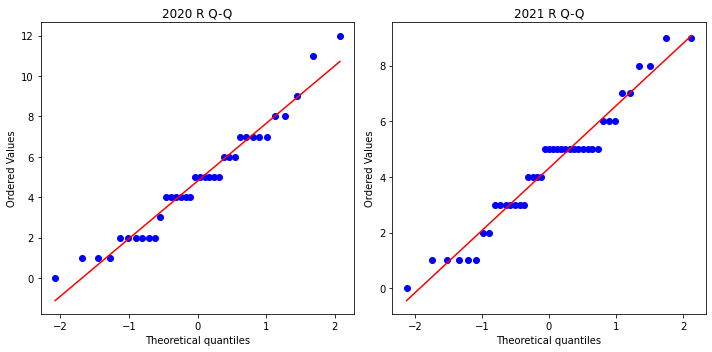

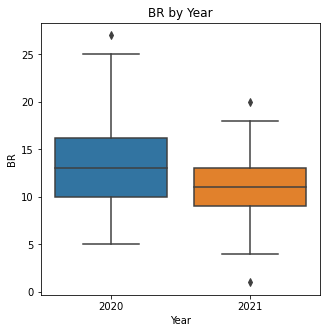

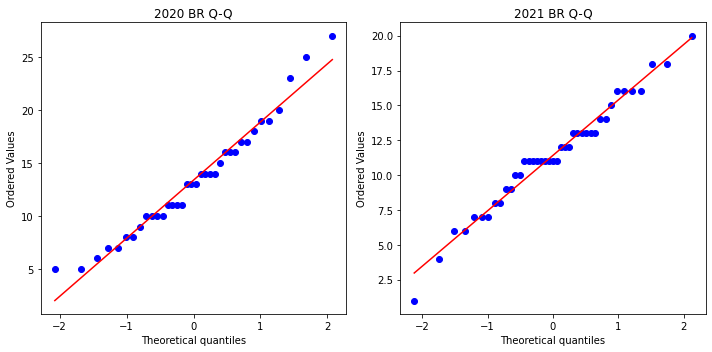

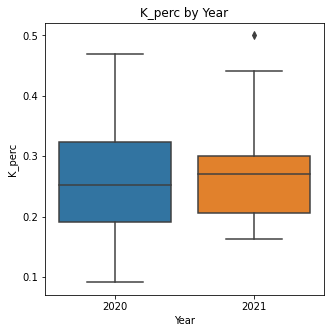

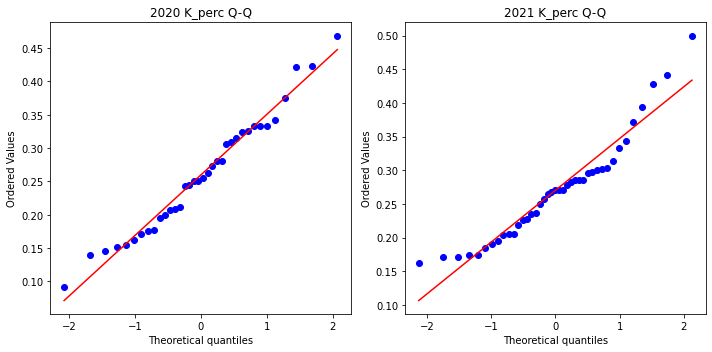

In [181]:
anova_analysis(data=close_df,x='Year',y='R')
anova_analysis(data=close_df,x='Year',y='BR')
anova_analysis(data=close_df,x='Year',y='K_perc')

Again, all of these metrics are not statistically significant at the level of p<0.05. However, the baserunner metric is very close with a p-value of 0.067 and an average difference of almost 2 baserunners per game. Either way, these overall numbers for losses and close games point to two other potential issues. <p>

The first would be the "clutch" hit. People have tried to define clutch and teach it for as long as I can remember watching sports. Perhaps 2020 was just a lucky year with the right hits coming at the right time. 2021 doesn't seem to be that much worse when looking at the big picture. <p>

The second would be that when the hitting shows up, perhaps the pitching doesn't. That would require a whole separate analysis, but for now we can conclude that while the team has been frustrating the exact cause isn't as simple as "the whole team is slumping". Timely hitting and a little bit of luck can turn a 2-1 loss into a 3-2 win.